## Imports and code

In [1]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from transformers import RobertaTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns


nltk.download('stopwords')
nltk.download('punkt')

/Users/rodolfocacacho/miniforge3/envs/lsd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rodolfocacacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rodolfocacacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
torch.cuda.is_available()

False

## Testing dataset

In [3]:
file_train = 'data/subtask1/train.json'
file_validation = 'data/subtask1/validation.json'

# Open the JSON file
with open(file, 'r') as file:
    # Load the JSON data
    data = json.load(file)

# Create a list of dictionaries
entries_list = []

# Iterate through each entry in the JSON data
for entry in data:
    # Extract relevant information from each entry
    entry_dict = {
        "id": entry["id"],
        "text": entry["text"],
        "labels": entry["labels"],
        "link": entry["link"]
    }

    # Append the dictionary to the list
    entries_list.append(entry_dict)

# Now 'entries_list' contains a list of dictionaries, each representing an entry in your JSON file
# You can access the information as needed
for entry_dict in entries_list:
    print(f"ID: {entry_dict['id']}, Text: {entry_dict['text']}, Labels: {entry_dict['labels']}, Link: {entry_dict['link']}")


NameError: name 'file' is not defined

In [ ]:
# Create a new list to store the preprocessed dictionaries
preprocessed_list = []

for entry in entries_list:
    preprocessed_entry = entry.copy()
    preprocessed_entry['text'] = preprocess_text(entry['text'])
    if len(preprocessed_entry['labels']) == 0:
        preprocessed_entry['labels'] = ['nocat']
    else:
        t = preprocessed_entry.get('labels',[0])[0]
        # print(f'aos {t}')
        preprocessed_entry['labels'] = [t]
        # preprocessed_entry['labels'] = preprocessed_entry['labels']    
    preprocessed_list.append(preprocessed_entry)


# Display the preprocessed data
for id,entry in enumerate(preprocessed_list):
    print(f"ID: {entry['id']}, Text: {entry['text']} Label: {entry['labels']}")
    # print(f"ID: {entries_list[id]['id']}, Text: {entries_list[id]['text']}")

In [4]:

# Initialize a dictionary to store label counts per category
category_counts = {}
ids_ohne_label = []
ids_mit_label = []
max_id = 0

# Loop through the dataset
for entry in preprocessed_list:
    labels = entry.get('labels', [])  # Get the labels for the current entry

    if not labels:
        ids_ohne_label.append(entry['id'])
    else:
        ids_mit_label.append(entry['id'])
        for label in labels:
            if label not in category_counts:
                category_counts[label] = 1
            else:
                category_counts[label] += 1
    if len(labels) > max_id:
        max_id = len(labels)
        idx = entry['id']


# Display the label counts per category
for category, count in category_counts.items():
    print(f"Category: {category}, Count: {count}")

f_list = [d for d in preprocessed_list if d.get('id') == idx]

print(f'ids ohne labels: {len(ids_ohne_label)} ids mit labels: {len(ids_mit_label)} max_labels {max_id}')
print(f'id {idx} text: {f_list}')

NameError: name 'preprocessed_list' is not defined

In [5]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the text for each entry in the dataset
for entry in preprocessed_list:
    text = entry['text']
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    # Update the entry with tokenized information
    entry['input_ids'] = tokens['input_ids']
    entry['attention_mask'] = tokens['attention_mask']

# Display the tokenized entries
for entry in preprocessed_list:
    print(f"ID: {entry['id']}")
    print(f"Text: {entry['text']}")
    print("Token IDs:", entry['input_ids'])
    print("Attention Mask:", entry['attention_mask'])
    print()

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

c:\ProgramData\miniconda3\envs\python3.9\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\meikf\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

NameError: name 'preprocessed_list' is not defined

## Functions

In [3]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)
    # Replace line breaks with a space
    text = text.replace('\\n', ' ')
    text = text.replace('\n', ' ')

    # Replace dashes with spaces
    text = text.replace('-', ' ')

    # Remove special characters, punctuation (except apostrophes), and symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    # stop_words = set(stopwords.words('english'))
    # tokens = [token for token in tokens if token not in stop_words]
    
    # Porter stemming (optional)
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def read_json_labels(file):
    # Open the JSON file
    with open(file, 'r') as file:
        # Load the JSON data
        data = json.load(file)

    # Create a list of dictionaries
    entries_list = []
    # Iterate through each entry in the JSON data
    for entry in data:
        # Extract relevant information from each entry
        entry_dict = {
            "id": entry["id"],
            "text": entry["text"],
            "labels": entry["labels"],
            "link": entry["link"]
        }

        # Append the dictionary to the list
        entries_list.append(entry_dict)
    
    return entries_list


def preprocess_text_list(entries_list):
    # Create a new list to store the preprocessed dictionaries
    preprocessed_list = []

    for entry in entries_list:
        preprocessed_entry = entry.copy()
        preprocessed_entry['text'] = preprocess_text(entry['text'])
        # if len(preprocessed_entry['labels']) == 0:
        #     preprocessed_entry['labels'] = ['nocat']
        # else:
        #     t = preprocessed_entry.get('labels',[0])[0]
        #     # print(f'aos {t}')
        #     preprocessed_entry['labels'] = [t]
        #     # preprocessed_entry['labels'] = preprocessed_entry['labels']    
        preprocessed_list.append(preprocessed_entry)
    
    return preprocessed_list

def preprocess_labels(entries_list):

    # Create a new list to store the preprocessed dictionaries
    preprocessed_list = []

    for entry in entries_list:
        preprocessed_entry = entry.copy()
        preprocessed_entry['text'] = preprocess_text(entry['text'])
        if len(preprocessed_entry['labels']) == 0:
            preprocessed_entry['labels'] = ['nocat']
        else:
            t = preprocessed_entry.get('labels',[0])[0]
            # print(f'aos {t}')
            preprocessed_entry['labels'] = [t]
            # preprocessed_entry['labels'] = preprocessed_entry['labels']    
        preprocessed_list.append(preprocessed_entry)

    return preprocessed_list

# def tokenize_text(preprocessed_list):
#     # Tokenize the text for each entry in the dataset
#     for entry in preprocessed_list:
#         text = entry['text']
#         tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

#         # Update the entry with tokenized information
#         entry['input_ids'] = tokens['input_ids']
#         entry['attention_mask'] = tokens['attention_mask']
    
#     return preprocessed_list

def tokenize_text(preprocessed_list, tokenizer):
    tokenized_list = []  # Create a new list to store tokenized entries

    # Tokenize the text for each entry in the dataset
    for entry in preprocessed_list:
        text = entry['text']
        tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

        # Create a new entry with tokenized information
        tokenized_entry = {
            'id': entry['id'],
            'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask']
        }

        tokenized_list.append(tokenized_entry)

    return tokenized_list

def extract_lists(data_list):
    texts = []
    ids = []
    labels = []

    for entry in data_list:
        text = entry.get('text', '')
        id_value = entry.get('id', '')
        label_value = entry.get('encoded_labels', [])

        texts.append(text)
        ids.append(id_value)
        labels.append(label_value)
        # labels.append(label_value)

    return texts, ids, labels

def binary_labels(label_list):
    # Filter out empty lists
    non_empty_lists = [labels for labels in label_list if labels]

    # Find the maximum label value across all examples (if there are non-empty lists)
    num_labels = max(max(labels) for labels in non_empty_lists) + 1 if non_empty_lists else 0

    # Convert encoded labels to binary vectors
    binary_vectors = []
    for encoded_labels in label_list:
        binary_vector = np.zeros(num_labels, dtype=int)
        binary_vector[encoded_labels] = 1
        binary_vectors.append(binary_vector.tolist())

    return binary_vectors

def to_encoded(binary_labels_tensor):

    binary_labels_list = binary_labels_tensor.cpu().numpy().tolist()
    indices_list = [np.where(np.atleast_1d(labels) == 1)[0].tolist() for labels in binary_labels_list]

    return indices_list

def validate_labels(model,data_loader,threshold = 0.5,device = 'cpu'):

    # Validation
    model.eval()
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            # Move batch tensors to the same device as the model
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = (torch.sigmoid(logits) > threshold).int()

            # val_preds = torch.argmax(logits, dim=1)
            
            # Move labels and predictions back to CPU and convert to numpy arrays
            all_val_labels.append(labels.cpu().numpy())
            all_val_preds.append(predicted_labels.cpu().numpy())

    # Flatten the list of numpy arrays
    all_val_labels = np.concatenate(all_val_labels)
    all_val_preds = np.concatenate(all_val_preds)

    # Convert to PyTorch tensors
    labels = torch.tensor(all_val_labels).long()
    predictions = torch.tensor(all_val_preds).long()

    return labels,predictions



In [4]:
file_train = 'data/subtask1/train.json'
file_validation = 'data/subtask1/validation.json'
# Create or load a label encoder
label_encoder = LabelEncoder()


# Train
train_json = read_json_labels(file_train)
train_list = preprocess_text_list(train_json)

# Extract labels from the data
all_labels = [label for item in train_list for label in item['labels']]

# Use LabelEncoder to fit and transform the labels
encoded_labels = label_encoder.fit_transform(all_labels)

# Update the data with encoded labels
for item in train_list:
    item['encoded_labels'] = label_encoder.transform(item['labels']).tolist()

train_text_list, train_id_list, train_labels_list = extract_lists(train_list)

train_labels_list_binary = binary_labels(train_labels_list)

train_tokens = tokenizer(train_text_list, padding=True, truncation=True, return_tensors="pt")
train_tokens_input_ids = train_tokens['input_ids']
train_tokens_mask_ids = train_tokens['attention_mask']

# train_list = tokenize_text(train_list,tokenizer)

# # Validation
val_json = read_json_labels(file_validation)
val_list = preprocess_text_list(val_json)

# Update the data with encoded labels
for item in val_list:
    item['encoded_labels'] = label_encoder.transform(item['labels']).tolist()

val_text_list, val_id_list, val_labels_list = extract_lists(val_list)

val_labels_list_binary = binary_labels(val_labels_list)


val_tokens = tokenizer(val_text_list, padding=True, truncation=True, return_tensors="pt")
val_tokens_input_ids = val_tokens['input_ids']
val_tokens_mask_ids = val_tokens['attention_mask']

## Don't run! Its just to run faster

In [7]:
# start = 542
n=100
# end = start+n
train_labels_list_binary = train_labels_list_binary[:n]
train_labels_list = train_labels_list[:n]
train_tokens_input_ids = train_tokens_input_ids[:n]
train_tokens_mask_ids = train_tokens_mask_ids[:n]

val_labels_list = val_labels_list[:n]
val_labels_list_binary = val_labels_list_binary[:n]
val_tokens_input_ids = val_tokens_input_ids[:n]
val_tokens_mask_ids = val_tokens_mask_ids[:n]

## Train and evaluation

In [8]:
# Create DataLoader
train_dataset = TensorDataset(train_tokens_input_ids, train_tokens_mask_ids, torch.tensor(train_labels_list_binary,dtype=torch.long))
val_dataset = TensorDataset(val_tokens_input_ids, val_tokens_mask_ids, torch.tensor(val_labels_list_binary,dtype=torch.long))

batch_size = 4
epochs = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

# Load pre-trained RoBERTa model and tokenizer
model_name = 'roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))
# tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5,eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs*len(train_dataloader))

# Loss Function
# criterion = torch.nn.BCEWithLogitsLoss()



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/rodolfocacacho/miniforge3/envs/lsd/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Average Training Loss: 0.6592732787132263


/Users/rodolfocacacho/miniforge3/envs/lsd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1/4, Validation F1-Score: 0.0
Epoch 2/4, Average Training Loss: 0.4571041190624237


/Users/rodolfocacacho/miniforge3/envs/lsd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2/4, Validation F1-Score: 0.0
Epoch 3/4, Average Training Loss: 0.37982036828994753


/Users/rodolfocacacho/miniforge3/envs/lsd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3/4, Validation F1-Score: 0.0
Epoch 4/4, Average Training Loss: 0.3602084732055664
Epoch 4/4, Validation F1-Score: 0.0


/Users/rodolfocacacho/miniforge3/envs/lsd/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


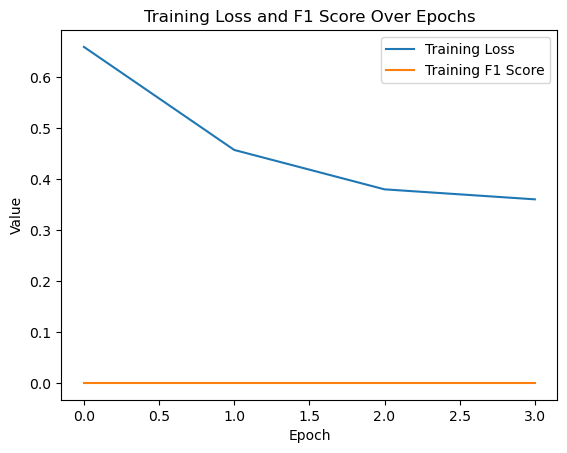

In [9]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to GPU
model = model.to(device)
threshold = 0.5
# Training Loop
losses = []
f1_scores = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        # Move batch tensors to the same device as the model
        input_ids, attention_mask, labels = batch
        # print(f'inputs {input_ids.shape} att_mask {attention_mask.shape} labels {labels.shape}')
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(torch.float).to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask,labels=labels)
        # print(f'outputs loss {outputs}')
        logits = outputs.logits
        loss = outputs.loss

        # print(f'logits {logits} labels {labels}')
        # loss = criterion(logits, labels)
        # print(f'outputs loss {loss.item()}')

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        
    
    # Print average training loss for the epoch
    average_loss = total_loss / len(train_dataloader)
    losses.append(average_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {average_loss}")

    labels,predictions = validate_labels(model,val_dataloader,threshold=threshold,device=device)

    # Calculate F1-score for validation set
    f1 = f1_score(labels, predictions, average='weighted',zero_division="warn")
    f1_scores.append(f1)
    print(f"Epoch {epoch + 1}/{epochs}, Validation F1-Score: {f1}")

# Plotting the loss and F1 score
plt.plot(losses, label='Training Loss')
plt.plot(f1_scores, label='Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and F1 Score Over Epochs')
plt.legend()
plt.show()

# # Save the model parameters to a file
# torch.save(model.state_dict(), 'model_parameters.pth')

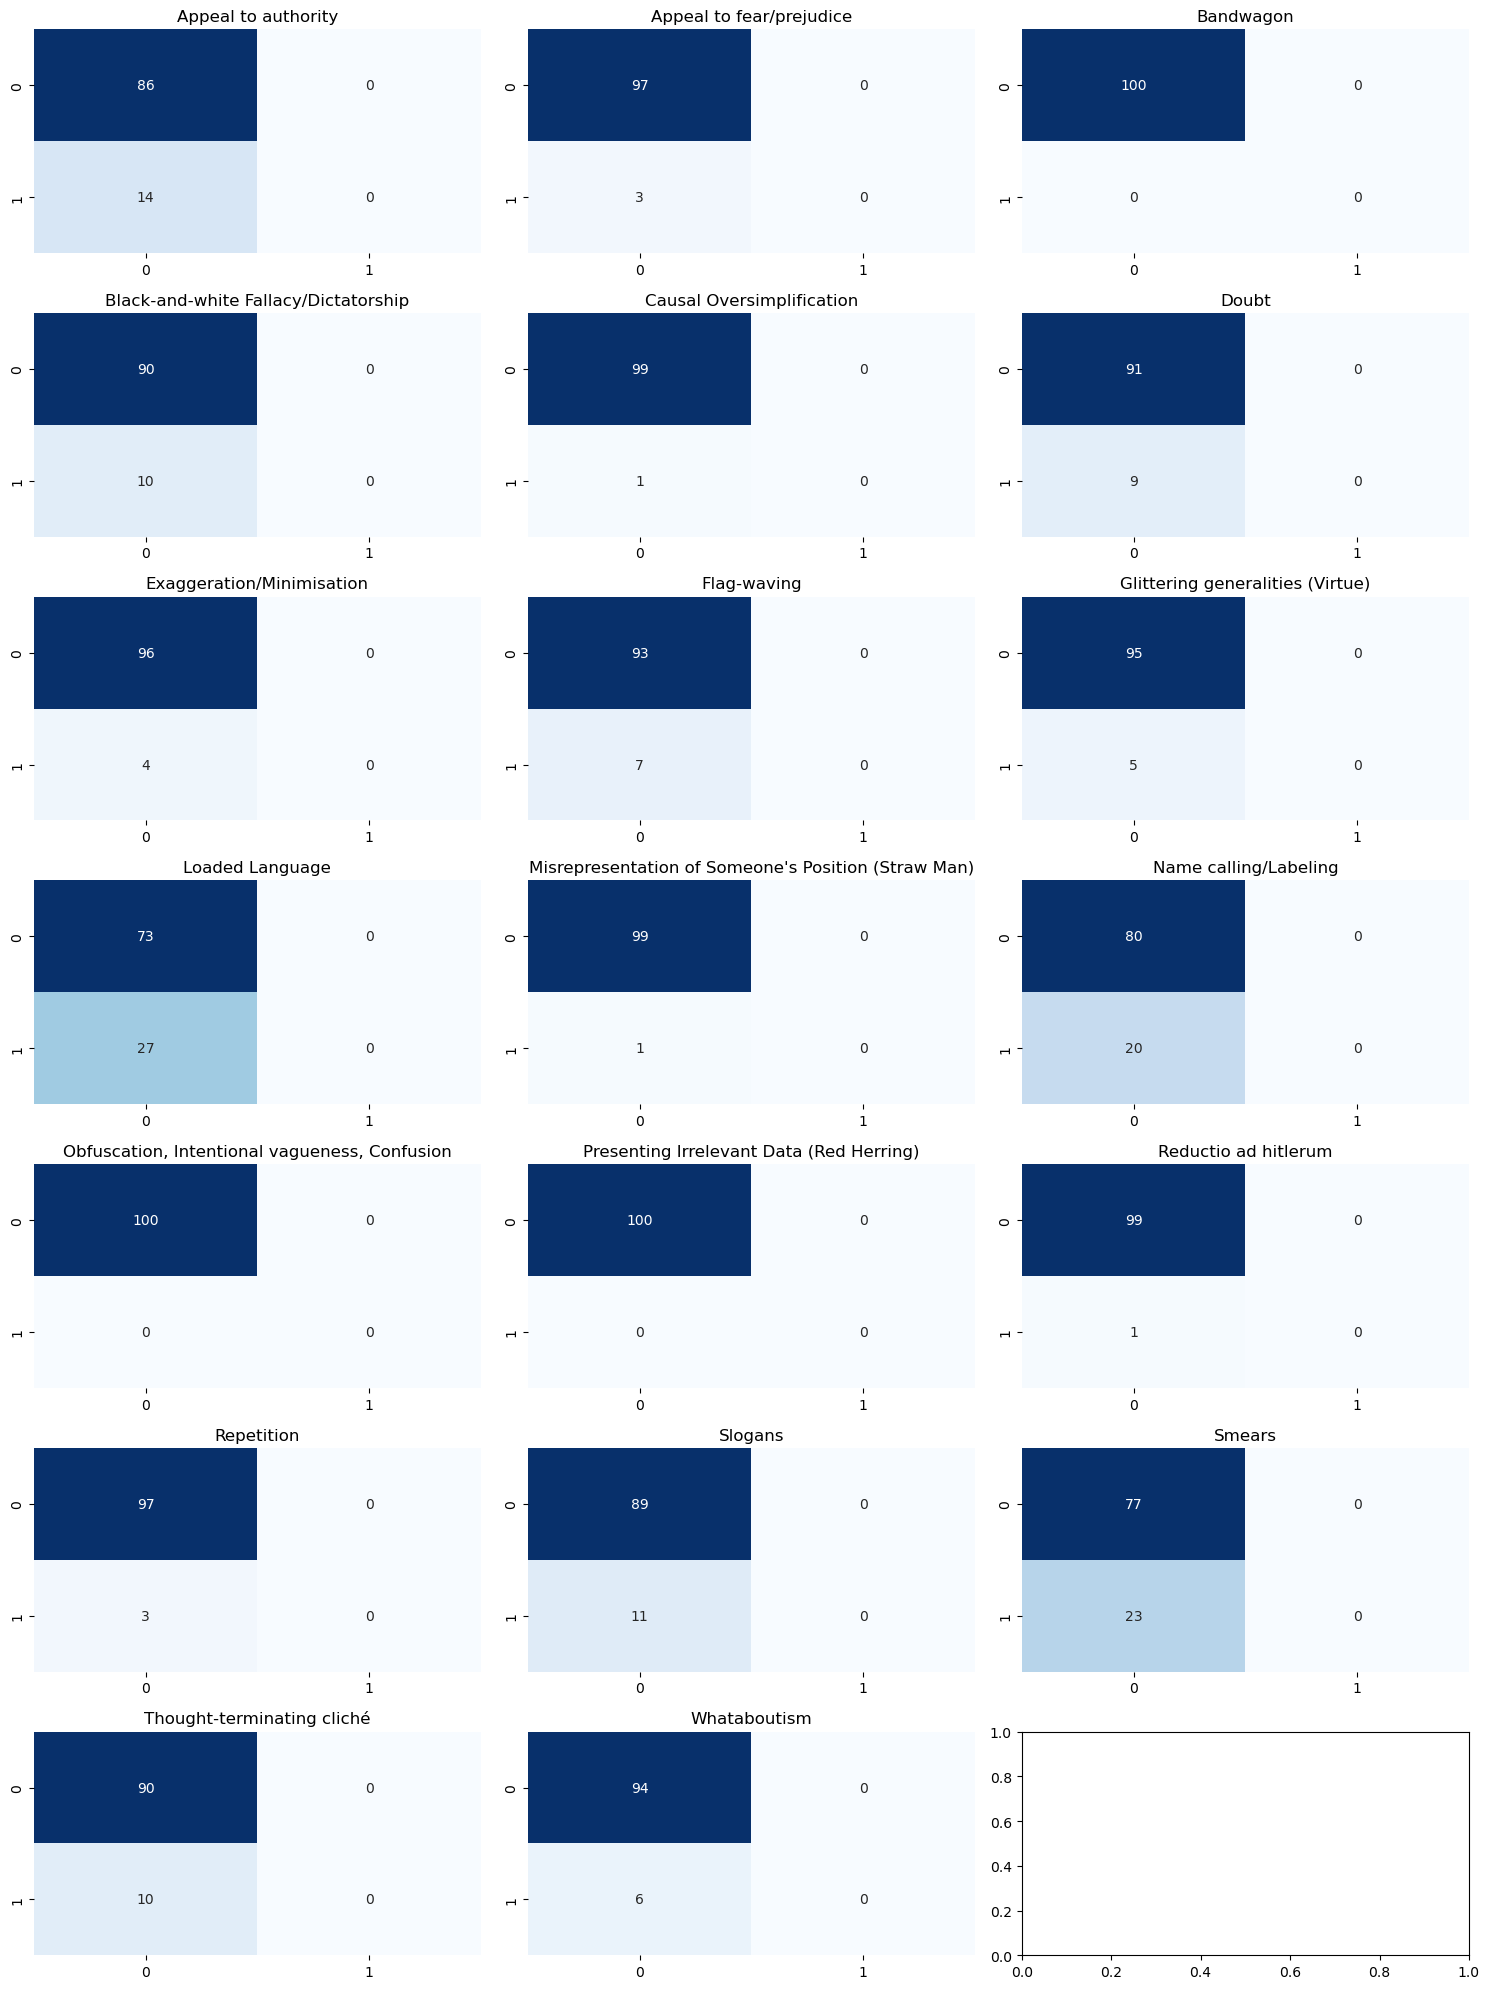

In [10]:
# Calculate multilabel confusion matrix
confusion_matrix_per_label = multilabel_confusion_matrix(labels, predictions)

# # Display confusion matrix for each label
# for i, confusion_matrix in enumerate(confusion_matrix_per_label):
#     print(f"Confusion Matrix for Label {i}:")
#     print(confusion_matrix)
#     print("\n")

# Plot confusion matrices using seaborn
num_labels = confusion_matrix_per_label.shape[0]

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    if i < num_labels:
        label_i = label_encoder.classes_[i]
        sns.heatmap(confusion_matrix_per_label[i], annot=True, fmt='d', cmap='Blues', cbar=False,
                    ax=ax, xticklabels=['0', '1'], yticklabels=['0', '1'])
        ax.set_title(f"{label_i}")

plt.tight_layout()
plt.show()


In [194]:
labels, predictions = validate_labels(model,val_dataloader,threshold=0.5)

In [195]:
list_labels_preds = to_encoded(predictions)
list_labels_orig = to_encoded(labels)

for i,val in enumerate(list_labels_orig):
    print(f'{i} orig: {val} pred: {list_labels_preds[i]}')


0 orig: [5, 16] pred: [9]
1 orig: [6, 17] pred: [9]
2 orig: [18] pred: [9]
3 orig: [8] pred: [9]
4 orig: [0, 16, 18] pred: [9]
5 orig: [7, 9, 11] pred: [9]
6 orig: [] pred: [9]
7 orig: [17] pred: [9]
8 orig: [7] pred: [9]
9 orig: [0, 11] pred: [9]
10 orig: [0, 9] pred: [9]
11 orig: [3] pred: [9]
12 orig: [17] pred: [9]
13 orig: [9, 11, 18] pred: [9]
14 orig: [0, 6, 7, 11] pred: [9]
15 orig: [11] pred: [9]
16 orig: [17] pred: [9]
17 orig: [8, 11, 17] pred: [9]
18 orig: [5, 9, 11] pred: [9]
19 orig: [5, 9] pred: [9]
20 orig: [16] pred: [9]
21 orig: [] pred: [9]
22 orig: [0, 11, 15] pred: [9]
23 orig: [5] pred: [9]
24 orig: [18] pred: [9]
25 orig: [9] pred: [9]
26 orig: [3] pred: [9]
27 orig: [9, 11, 17] pred: [9]
28 orig: [] pred: [9]
29 orig: [3, 9] pred: [9]
30 orig: [] pred: [9]
31 orig: [9] pred: [9]
32 orig: [10] pred: [9]
33 orig: [5, 7, 16] pred: [9]
34 orig: [] pred: [9]
35 orig: [3] pred: [9]
36 orig: [] pred: [9]
37 orig: [6, 17] pred: [9]
38 orig: [15, 18] pred: [9]
39 orig: [